### **Para o problema de ajuste de curva dos Trabalhos 3 e 4:**

**1- Identificar se você realizou o treinamento em batelada, tempo real ou mini-batch;**

**2- Fazer o código de treinamento em mini-batch e testar a variação de MB, incluindo MB igual ao total de dados (batelada) e MB=1 (tempo real). Comparar os resultados.**





O método de treinamento em mini-lote é uma abordagem confrontada entre o treinamento em batelada (usando o conjunto de dados completo em cada iteração) e o treinamento online (usando um único exemplo por vez). No treinamento em mini-lote, você divide o conjunto de dados completo em pequenos subconjuntos chamados mini-lotes e atualiza os parâmetros do modelo após processar cada mini-lote. Essa abordagem combina algumas vantagens de ambos os métodos, permitindo eficiência computacional e estabilidade nas atualizações dos parâmetros.

Mas de ínicio é necessário importar os dados, normaliza-los e definir nossa função de custo:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# @brief: importa dados do excel
def GetData():
  df = pd.read_excel("/content/drive/MyDrive/ColabNotebooks/Trabalho3dados.xlsx")
  x = df['x']
  y = df['y']
  z = df['z']
  return(np.array([x, y, z]))

In [ ]:
def ZScore(Data):
  return ((Data - np.mean(Data)) / np.std(Data))

def DenormalizeData(Data, Orig):
  return (Data * Orig.std() + Orig.mean())

def GetNormData():
  x = GetData()
  for i in range(len(x)):
    x[i] = ZScore(x[i])
  return (x)

Nos trabalhos 3 e 4 os algoritmos do gradiente descendente e levenberg-marquadt foram implementados a fim de minimizar a função de custo relacionada a equação de ajuste de curva $z = ax^3+by^2+c$ e o conjunto de dados importados.



In [ ]:
def CurveFitFunction(p, x):
    return ((p[0] * x[0]**3) + (p[1] * x[1]**2) + p[2])

def MSE(zPred, zReal):
    return (np.mean(zReal - zPred)**2)

def GradMSE(x, zReal, zPred, n=1):
    errors = (zPred - zReal)
    GradA = 2/n * np.sum((x[0] ** 3) * errors)
    GradB = 2/n * np.sum((x[1] ** 2) * errors)
    GradC = 2/n * np.sum((1) * errors)
    return [GradA, GradB, GradC]

def HessianaMSE(x, n=1):
    HessianAA = 2/n * np.sum(x[0] ** 6)
    HessianAB = 2/n * np.sum((x[0] ** 3) * (x[1] ** 2))
    HessianAC = 2/n * np.sum(x[0] ** 3)
    HessianBA = 2/n * np.sum((x[0] ** 3) * (x[1] ** 2))
    HessianBB = 2/n * np.sum(x[1] ** 4)
    HessianBC = 2/n * np.sum(x[1] ** 2)
    HessianCA = 2/n * np.sum(x[0] ** 3)
    HessianCB = 2/n * np.sum(x[1] ** 2)
    HessianCC = 2
    return np.array([[HessianAA, HessianAB, HessianAC],
                     [HessianBA, HessianBB, HessianBC],
                     [HessianCA, HessianCB, HessianCC]])

In [ ]:
def GetZDenorm(p, ZOrig):
  x = GetNormData()
  X, Y = np.meshgrid(np.linspace(min(x[0]), max(x[0]), 100),
                     np.linspace(min(x[1]), max(x[1]), 100))
  ZNorm = (CurveFitFunction(p, [X, Y]))
  ZDenorm = DenormalizeData(CurveFitFunction(p, [X, Y]), ZOrig)
  return (ZDenorm)

def GetSurface(x, k, alpha, Version):
  p, HistCost = SetGradVersion(Version, [1.0, 1.0, 1.0], k, alpha)
  X, Y = np.meshgrid(np.linspace(min(x[0]), max(x[0]), 100),
                     np.linspace(min(x[1]), max(x[1]), 100))
  Z = GetZDenorm(p, x[2])
  return (X, Y, Z, HistCost)

def ConfGraph3D(ax, x, y, z, title):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title(title)

def PlotSurface(fig, X, Y, Z, label):
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.plot_surface(X, Y, Z, alpha=0.8, cmap='viridis')
  ConfGraph3D(ax, 'x', 'y', 'z', "Ajuste de curva por descida de de gradiente" + label)
  return (ax)

def PlotCosts(fig, Hist, label):
  ax = fig.add_subplot(1, 2, 2)
  k = np.linspace(0, len(Hist), len(Hist), dtype=int)
  ax.plot(k, Hist)
  ax.set_xlabel('Iterações (k)')
  ax.set_ylabel('Custo')
  ax.set_title("Histórico de custo da descida de gradiente" + label)
  ax.grid(True)

def TestCostFunc(Version, label, K=1000, alpha=0.001):
  x = GetData()
  fig = plt.figure(figsize=(12, 6))
  X, Y, Z, HistCost = GetSurface(x, K, alpha, Version)
  ax = PlotSurface(fig, X, Y, Z, label)
  ax.scatter(x[0], x[1], x[2], c='blue', marker='o')
  PlotCosts(fig, HistCost, label)

Existem algumas variantes do algoritmo de descida de gradiente. A principal diferença entre eles é a quantidade de dados que usamos ao calcular os gradientes para cada etapa de aprendizado. Essas variantes definem o tipo de treinamento, batch, estocástico, online ou mini-batch.

In [ ]:
def CheckCost(HistCost, tol=0.0001):
  if (len(HistCost) <= 2):
    return False
  return (abs(HistCost[-1] - HistCost[-2]) < tol)

def SetGradVersion(Version, p, K, alpha):
  if (Version == "Batch"):
    return (GradBatch(p, K, alpha))
  if (Version == "MiniBatch"):
    return (GradMiniBatch(p, K, alpha))
  if (Version == "Stochastic"):
    return (GradStochastic(p, K, alpha))

## 1.Descida de gradiente em lote

Na descida de gradiente em batch, todo o conjunto de dados $x$ é utilizado para atualizar os parâmetros do modelo de uma só vez.

$$ w_{k+1} = w_k - \alpha . \nabla_w J(x, y; w) $$

Assim, todo o conjunto de treinamento é usado para calcular o gradiente da função de custo em relação aos parâmetros do modelo em cada iteração (época). Isso significa que o gradiente é calculado com base em todas as exceções de treinamento de uma só vez. O modelo é atualizado uma vez por época com base no gradiente médio calculado

In [ ]:
def GradBatch(p, K, alpha):
    HistCost =  []
    DataNorm = GetNormData()
    zReal = DataNorm[2]
    while (CheckCost(HistCost) == False):
        zPred = CurveFitFunction(p, DataNorm)
        HistCost.append(MSE(zPred, zReal))
        Jx = GradMSE(DataNorm, zReal, zPred, n=len(DataNorm[0]))
        #Jxx = HessianaMSE(DataNorm, n=len(DataNorm[0]))
        #deltaP = np.dot(np.linalg.inv(Jxx + np.dot(alpha, np.eye(3))), Jx)
        deltaP = np.dot(Jx, alpha)
        p = p - deltaP
        K -= 1
        if (K == 0):
          break
    return (p, HistCost)

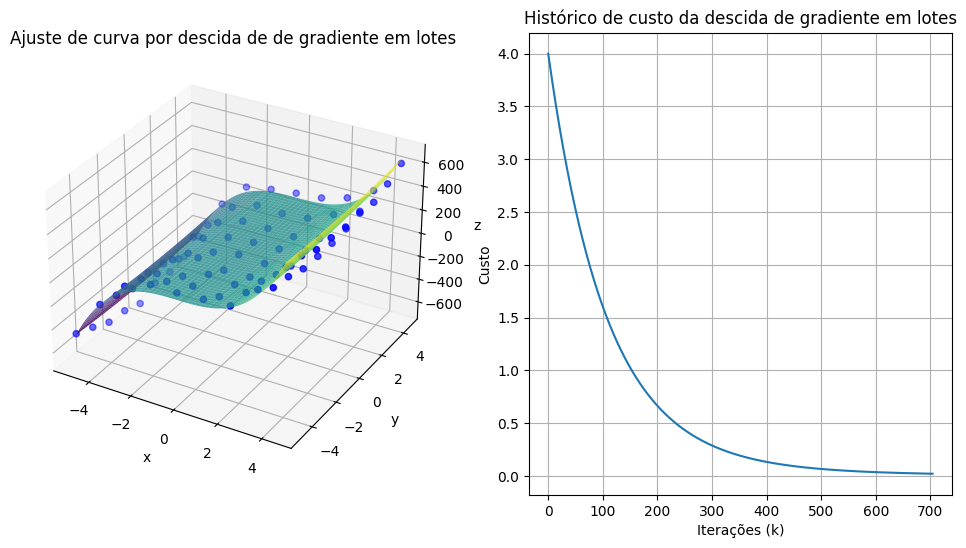

In [ ]:
TestCostFunc(Version="Batch", label=" em lotes")

## 2.Descida de gradiente em mini lotes

Em vez de examinar todo o conjunto de dados $x$, a descida de gradiente de minilotes separa o conjunto total em lotes menores. Para isso, primordialmente é necessário realizar o emabaralhamento dos dados devido á alguns fatores como o modelo se tornar sensível à sequência dos exemplos e não generalizar bem para novos dados.

Embaralhar os dados evita esse viés, usar mini-lotes aleatórios ajuda a evitar que o algoritmo fique preso em mínimos locais e explore diferentes regiões do espaço de parâmetros. Isto é importante para que o modelo aprenda a partir de uma variedade de exemplos e seja capaz de generalizar bem.

Assim, o aprendizado acontece em cada mini-lote $b$ de  dados seguindo a equação:

$$ w_{k+1} = w_k - \alpha . \nabla_w J(x^{[k:k+b]}, y^{[k:k+b]}; w) $$

se $N$ não for divisível por $b$, o tamanho do lote atual sera o próprio resto.

In [ ]:

def GradMiniBatch(p, K, alpha, batchSize=16):
    HistCost =  []
    DataNorm = GetNormData()
    zReal = DataNorm[2]
    while (CheckCost(HistCost) == False):
        zPred = CurveFitFunction(p, DataNorm)
        HistCost.append(MSE(zPred, zReal))
        np.random.shuffle(DataNorm)
        for i in range(0, len(DataNorm[0]), batchSize):
            xBatch = DataNorm[0][i:i+batchSize]
            yBatch = DataNorm[1][i:i+batchSize]
            zBatch = DataNorm[2][i:i+batchSize]
            BatchData = [xBatch, yBatch, zBatch]
            zBatchPred = CurveFitFunction(p, BatchData)
            JxBatch = GradMSE(BatchData, zBatch, zBatchPred, n=len(BatchData[0]))
            #Jxx = HessianaMSE(BatchData)
            #deltaP = np.dot(np.linalg.inv(Jxx + np.dot(alpha, np.eye(3))), JxBatch)
            deltaP = np.dot(JxBatch, alpha)
            p = p - deltaP
        K -= 1
        if (K == 0):
          break
    return (p, HistCost)



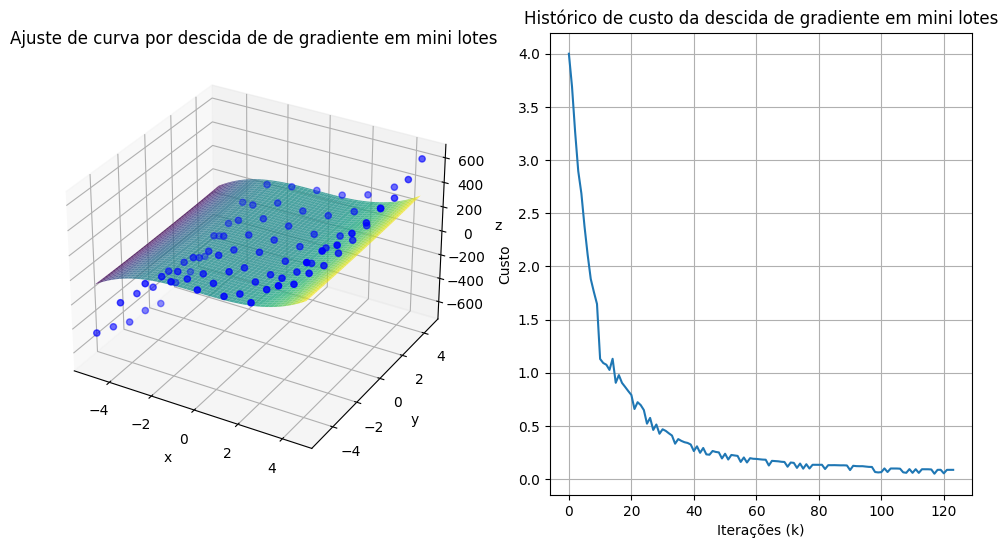

In [ ]:
TestCostFunc(Version="MiniBatch", label=" em mini lotes")

## 3. Descida de Gradiente estocástica e em tempo real


O Stochastic Gradient Descent (SGD) realiza a atualização dos parâmetros após cada amostra de treinamento individual $(x^i,y^i)$, isso significa que, para cada amostra, o gradiente é calculado e os parâmetros são atualizados imediatamente.                                                     $$ w_{k+1} = w_k - \alpha . \nabla_w J(x^{i}, y^{i}; w) $$
A maioria de suas vantagens e desvantagens são as mesmas da versão mini-lote, mas as que são específicas para SGD é que, é adicionado ainda mais ruído ao processo de aprendizado do que o mini-lote, que ajuda a melhorar o erro de generalização e aumenta o tempo de execução. Não se pode utilizar a vetorização em 1 exemplo que fica muito lento e tornando a variação grande.

In [ ]:
def GradStochastic(p, K, alpha):
    HistCost =  []
    DataNorm = GetNormData()
    zReal = DataNorm[2]
    while (CheckCost(HistCost) == False):
        zPred = CurveFitFunction(p, DataNorm)
        HistCost.append(MSE(zPred, zReal))
        np.random.shuffle(DataNorm)
        for example in DataNorm:
            xBatch = example[0]
            yBatch = example[1]
            zBatch = example[2]
            BatchData = [xBatch, yBatch, zBatch]
            zBatchPred = CurveFitFunction(p, BatchData)
            JxBatch = GradMSE(BatchData, zBatch, zBatchPred)
            #Jxx = HessianaMSE(BatchData)
            #deltaP = np.dot(np.linalg.inv(Jxx + np.dot(alpha, np.eye(3))), JxBatch)
            deltaP = np.dot(alpha, JxBatch)
            p = p - deltaP
        K -= 1
        if (K == 0):
          break
    return (p, HistCost)

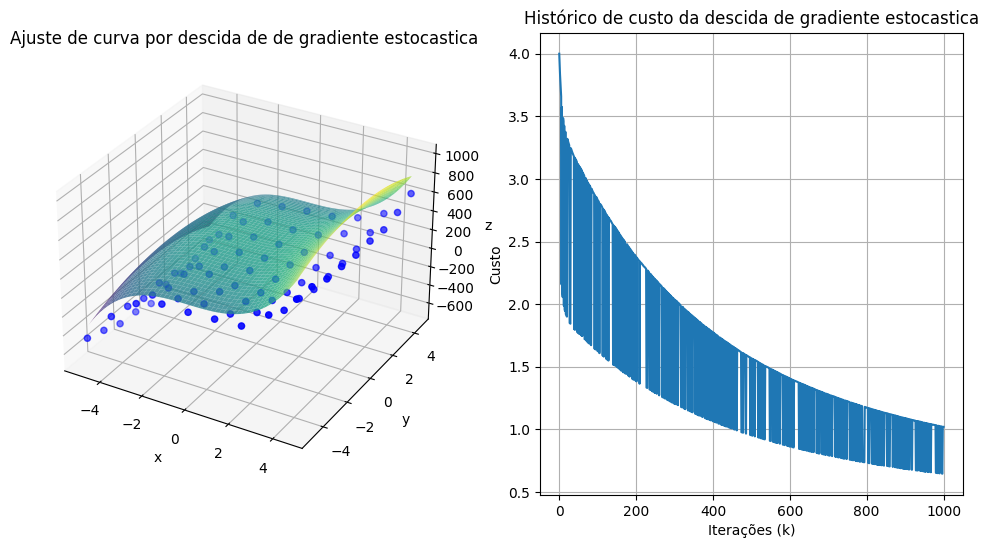

In [ ]:
TestCostFunc(Version="Stochastic", label=" estocastica")